In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import scirpy as ir
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/home/yyasumizu/anaconda3/envs/scanpy1.8.1_cd4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/yyasumizu/anaconda3/envs/scanpy1.8.1_cd4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '230210_NMFprojection_ImmunexUT'

n_comp = 12


import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.5.3 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [3]:
import glob

In [4]:
list_f = glob.glob('../data/E-GEAD-397_ImmuNexUT/*_count.txt')
list_f

['../data/E-GEAD-397_ImmuNexUT/CD16p_Mono_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/CL_Mono_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/CM_CD8_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/DN_B_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/EM_CD8_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Fr_III_T_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Fr_II_eTreg_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Fr_I_nTreg_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Int_Mono_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/LDG_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Mem_CD4_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Mem_CD8_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/NC_Mono_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/NK_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Naive_B_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Naive_CD4_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Naive_CD8_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Neu_count.txt',
 '../data/E-GEAD-397_ImmuNexUT/Plasmablast_count.txt',
 '../data/E-GEAD-397_ImmuNexU

In [5]:
list_w = ['CD4T', 'B', 'PBMC']

In [26]:
list_cells = [f.split('/')[-1].split('_count.txt')[0] for f in list_f]
list_cd4t = [ 'Fr_III_T',
 'Fr_II_eTreg',
 'Fr_I_nTreg',
 'Mem_CD4',
 'Naive_CD4',
 'Tfh',
 'Th17',
 'Th1',
 'Th2']
list_b = [ 'DN_B',
 'Naive_B',
 'Plasmablast',
 'SM_B',
 'USM_B']
list_cat = [('All', list_cells), ('CD4T', list_cd4t), ('B', list_b)]

In [27]:
df_samples = pd.read_csv('../data/E-GEAD-397_ImmuNexUT/clinical_diagnosis_age_sex_v2.txt', sep='\t')

# remove AAV, AOSD, SjS, BD to remove Moflo effet
list_dis = ['SSc', 'IIM', 'HC', 'SLE', 'RA', 'TAK', 'MCTD']
df_samples = df_samples.loc[df_samples.disease.isin(list_dis)]
df_samples.head()

id disease  Phase  age sex
0  NW100328     SSc      2   53   F
1  NW100388     IIM      2   56   F
2  NW100405     SSc      2   78   F
3  NW100509     IIM      1   60   M
4  NW100766      HC      2   46   F

In [28]:
list_cat = [('All', list_cells), ('CD4T', list_cd4t), ('B', list_b)]
for cat, l_c in list_cat:
    l_d = [pd.read_csv('../data/E-GEAD-397_ImmuNexUT/{}_TPM.tsv'.format(c), sep='\t', index_col=0) for c in l_c]
    for i,c in enumerate(l_c):
        l_d[i].columns = l_d[i].columns + '_' + c
    d = pd.concat(l_d, axis=1)
    # 230112 added
    d = d[[x for x in d.columns if x.split('_')[0] in list(df_samples['id'])]]
    d.to_csv('../data/E-GEAD-397_ImmuNexUT/230112_{}_TPM.tsv'.format(cat), sep='\t')

In [29]:
list_cat = [('All', list_cells), ('CD4T', list_cd4t), ('B', list_b)]
for cat, l_c in list_cat:
    for w in list_w:
        cmd = 'NMFproj '\
        '--outputprefix /home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/230112_{c}_{w} ' \
        '../data/E-GEAD-397_ImmuNexUT/230112_{c}_TPM.tsv ' \
        '~/media32TB/bioinformatics/yyoshiaki-git/NMFprojection/data/NMF.W.{w}.csv.gz'.format(w=w, c=cat)
        print(cmd)

NMFproj --outputprefix /home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/230112_All_CD4T ../data/E-GEAD-397_ImmuNexUT/230112_All_TPM.tsv ~/media32TB/bioinformatics/yyoshiaki-git/NMFprojection/data/NMF.W.CD4T.csv.gz
NMFproj --outputprefix /home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/230112_All_B ../data/E-GEAD-397_ImmuNexUT/230112_All_TPM.tsv ~/media32TB/bioinformatics/yyoshiaki-git/NMFprojection/data/NMF.W.B.csv.gz
NMFproj --outputprefix /home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/230112_All_PBMC ../data/E-GEAD-397_ImmuNexUT/230112_All_TPM.tsv ~/media32TB/bioinformatics/yyoshiaki-git/NMFprojection/data/NMF.W.PBMC.csv.gz
NMFproj --outputprefix /home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/230112_CD4T_CD4T ../data/E-GEAD-397_ImmuNexUT/230112_CD4T_TPM.tsv ~/media32TB/bioinformatics/yyoshiaki-git/NMFprojection/data/NMF.W.CD4T.csv.gz
NMFproj --outputprefix /

In [11]:
list_cat = ['All', 'CD4T', 'B']
for cat in list_cat:
    for w in list_w:
#         df_proj = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_projection.csv'.format(c=cat, w=w), 
#             index_col=0)
        print('Category :', cat, 'W :',w)
        df_evar = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/230112_{c}_{w}_ExplainedVariance.csv'.format(c=cat, w=w), 
            index_col=0)
        print(df_evar.loc['ALL', 'ExplainedVariance'])

Category : All W : CD4T
0.8392583604644485
Category : All W : B
0.8354430698075106
Category : All W : PBMC
0.8934055346701156
Category : CD4T W : CD4T
0.8839971881902695
Category : CD4T W : B
0.8446106757314329
Category : CD4T W : PBMC
0.9026903708142212
Category : B W : CD4T
0.820229353248137
Category : B W : B
0.8602856042795746
Category : B W : PBMC
0.8985936402355466


In [12]:
cat = 'CD4T'
w = 'CD4T'
df_proj = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_projection.csv'.format(c=cat, w=w), 
    index_col=0)
df_evar = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_ExplainedVariance.csv'.format(c=cat, w=w), 
    index_col=0)

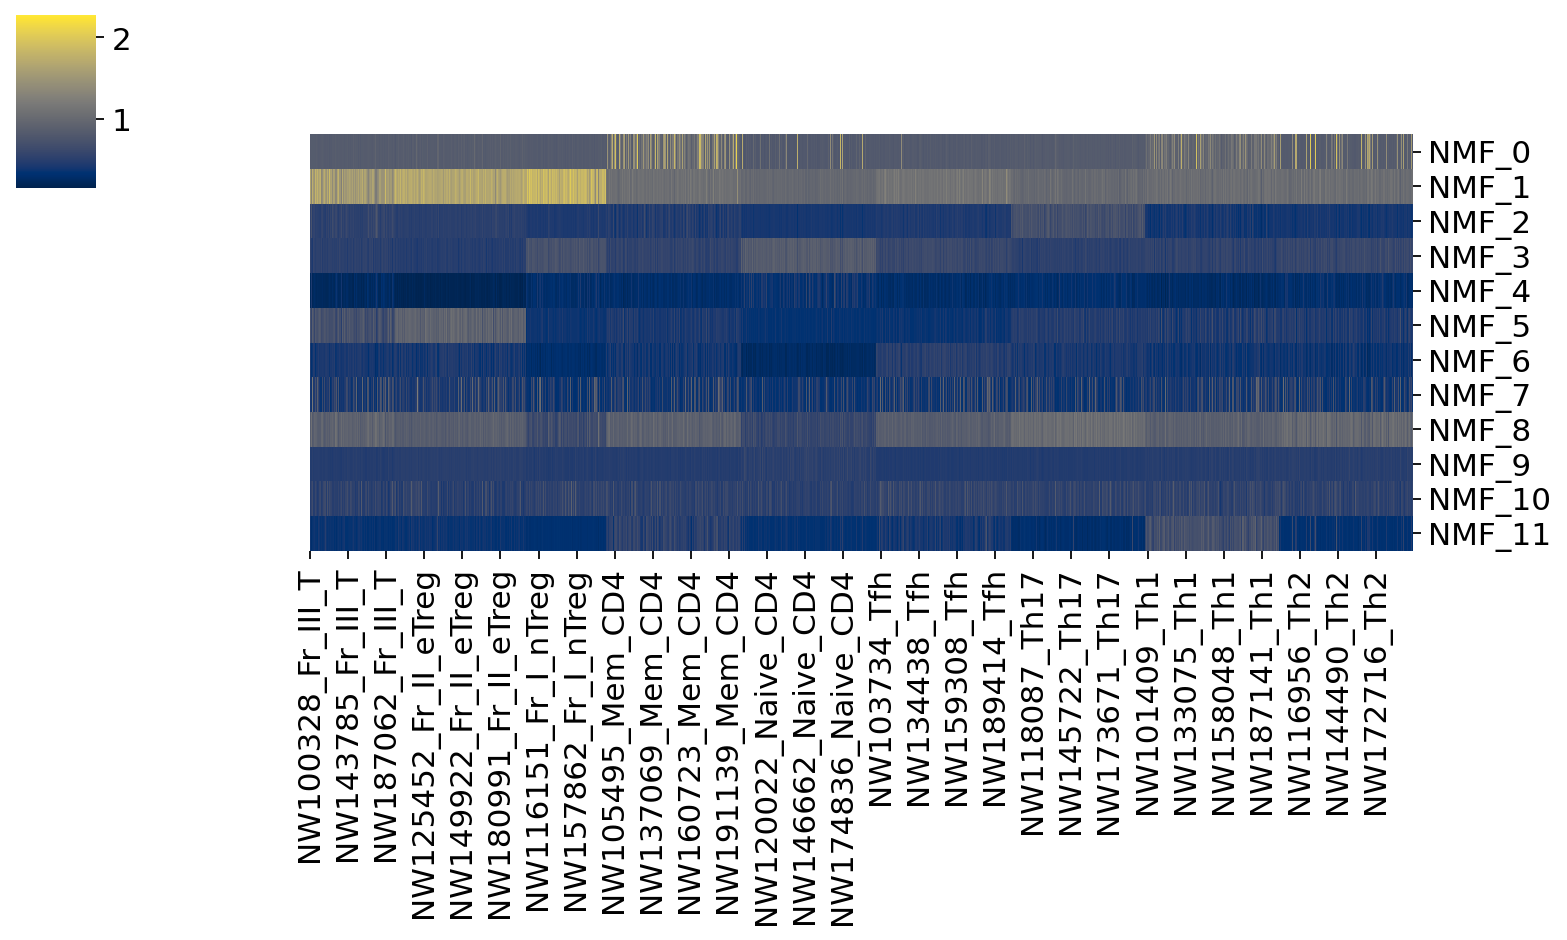

In [13]:
sns.clustermap(df_proj, col_cluster=False, row_cluster=False, figsize=(10,6), cmap='cividis')

In [14]:
df_proj_tidy = df_proj.T
df_proj_tidy['id'] = df_proj_tidy.index.str.split('_').str.get(0)
df_proj_tidy['cell'] = ['_'.join(x[1:]) for x in df_proj_tidy.index.str.split('_')]
df_proj_tidy = pd.merge(df_proj_tidy, df_samples)
df_proj_tidy.head()

NMF_0     NMF_1     NMF_2     NMF_3     NMF_4     NMF_5     NMF_6  \
0  0.787743  1.840433  0.497855  0.498283  0.217033  0.734613  0.474020   
1  0.797681  1.841626  0.512311  0.456707  0.194075  0.903180  0.475895   
2  0.798987  1.937421  0.426739  0.722132  0.285608  0.373841  0.285964   
3  0.805448  1.096314  0.493427  0.589333  0.313920  0.402874  0.464001   
4  0.787572  0.966639  0.417979  0.895262  0.392489  0.353317  0.258974   

      NMF_7     NMF_8     NMF_9    NMF_10    NMF_11        id         cell  \
0  0.444315  0.763244  0.481078  0.702570  0.376019  NW100328     Fr_III_T   
1  0.466712  0.759131  0.494899  0.702866  0.380745  NW100328  Fr_II_eTreg   
2  0.377513  0.563373  0.476493  0.731301  0.341540  NW100328   Fr_I_nTreg   
3  0.417629  0.842121  0.476049  0.705729  0.468777  NW100328      Mem_CD4   
4  0.383583  0.529665  0.533436  0.492159  0.359469  NW100328    Naive_CD4   

  disease  Phase  age sex  
0     SSc      2   53   F  
1     SSc      2   53   F  
2     SSc      2   53   F  
3     SSc      2   53   F  
4     SSc      2   53   F

In [15]:
df_proj_tidy.disease.unique()

array(['SSc', 'HC', 'IIM', 'SLE', 'RA', 'TAK', 'MCTD'], dtype=object)

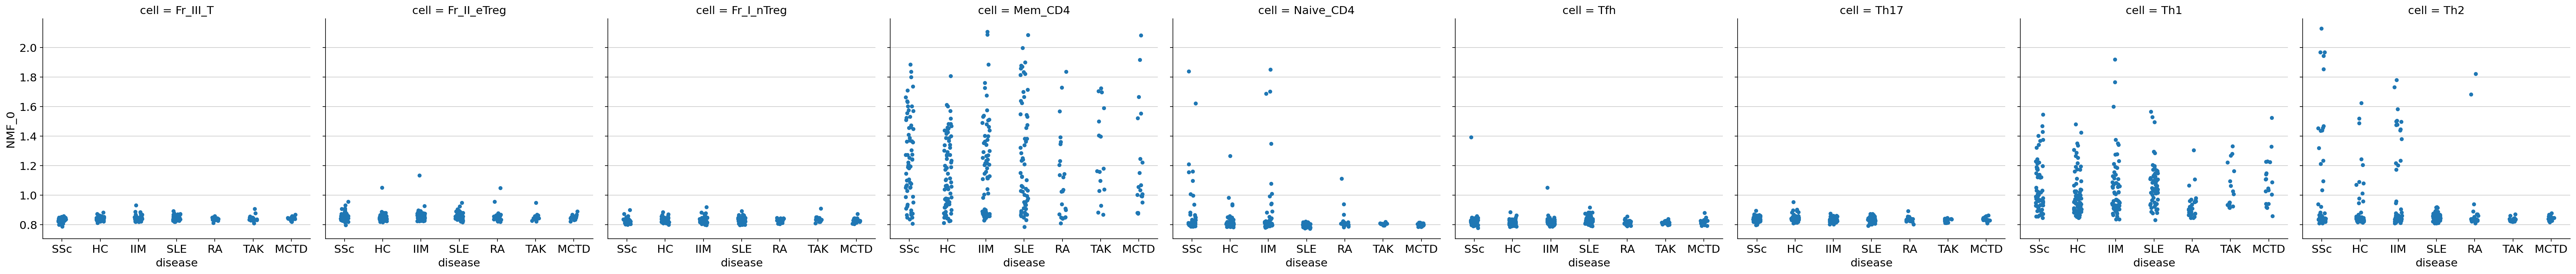

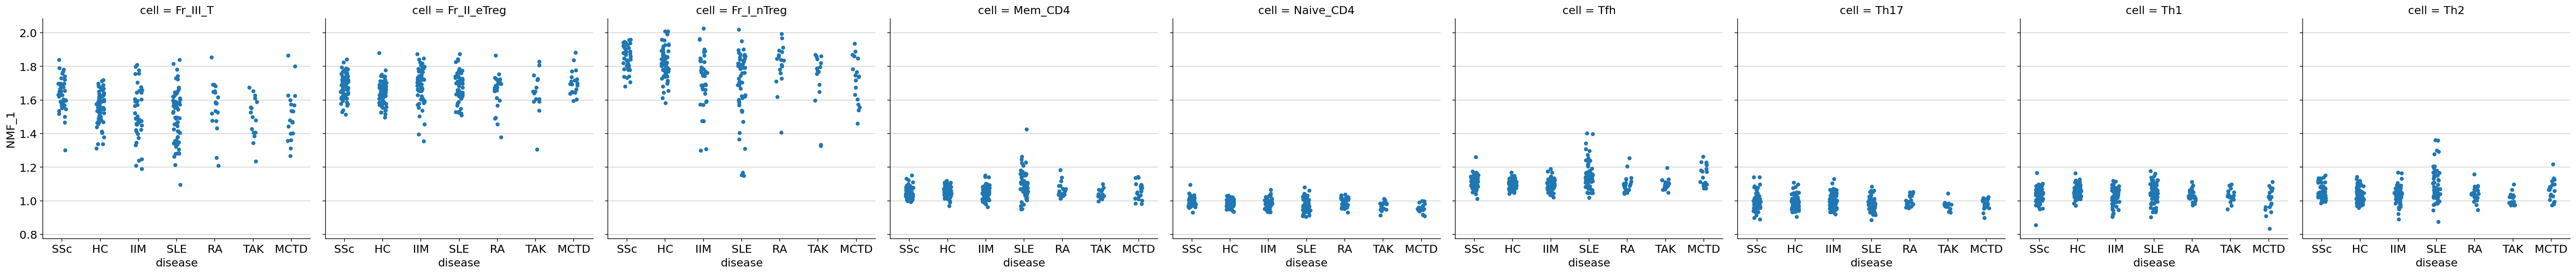

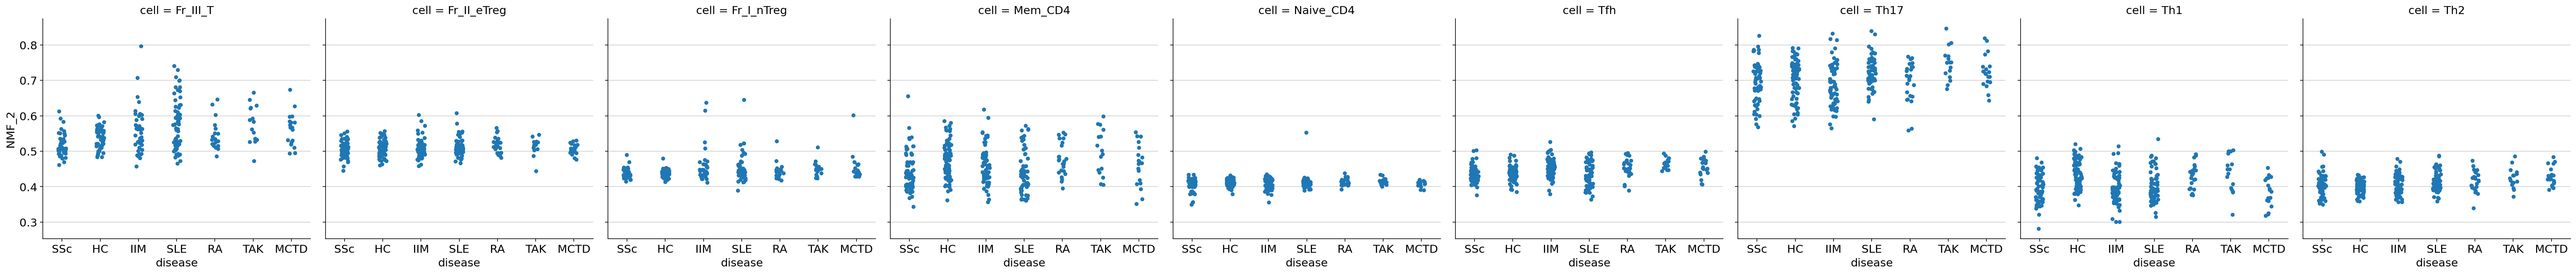

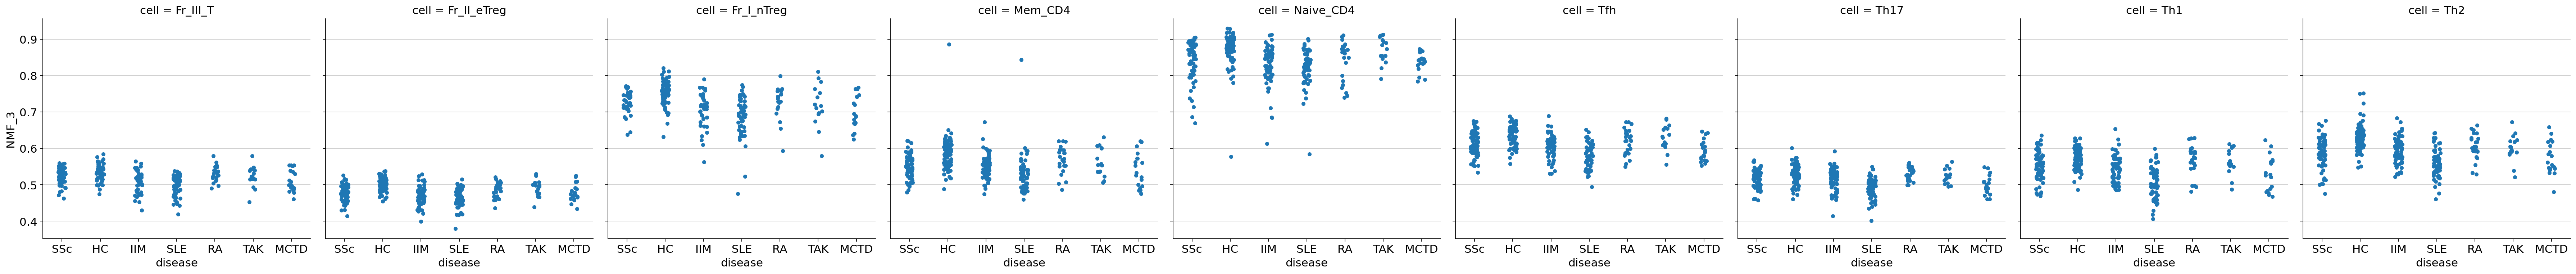

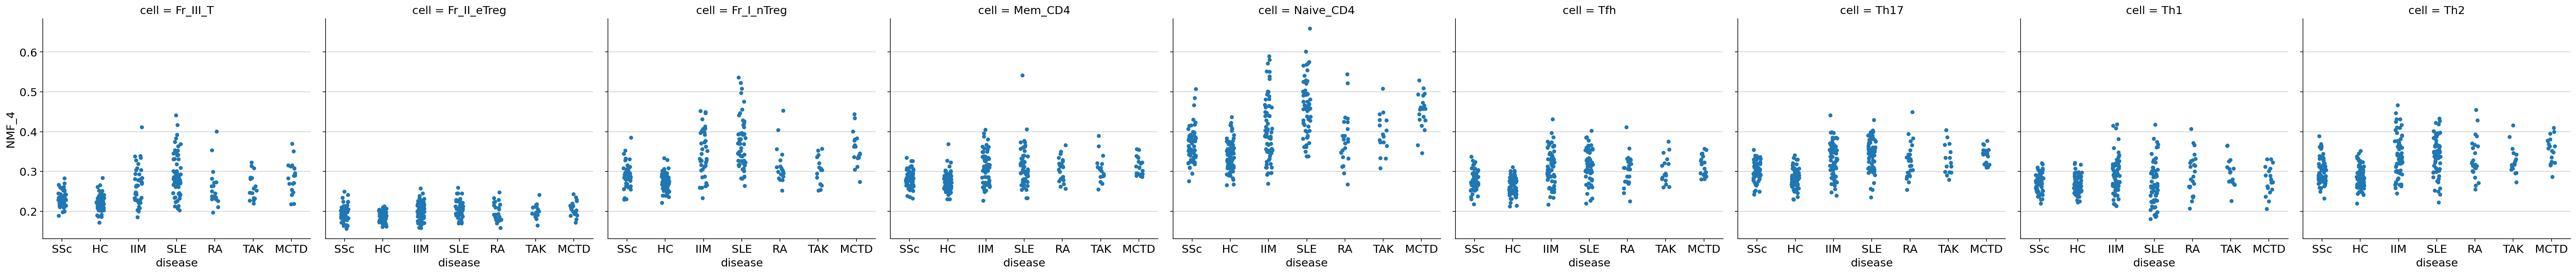

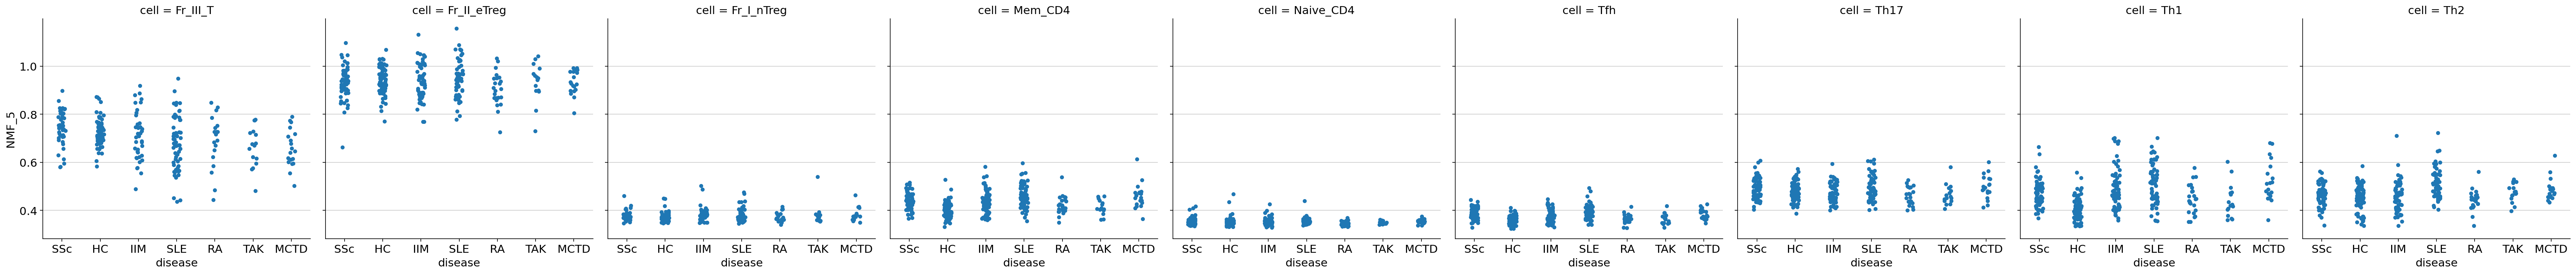

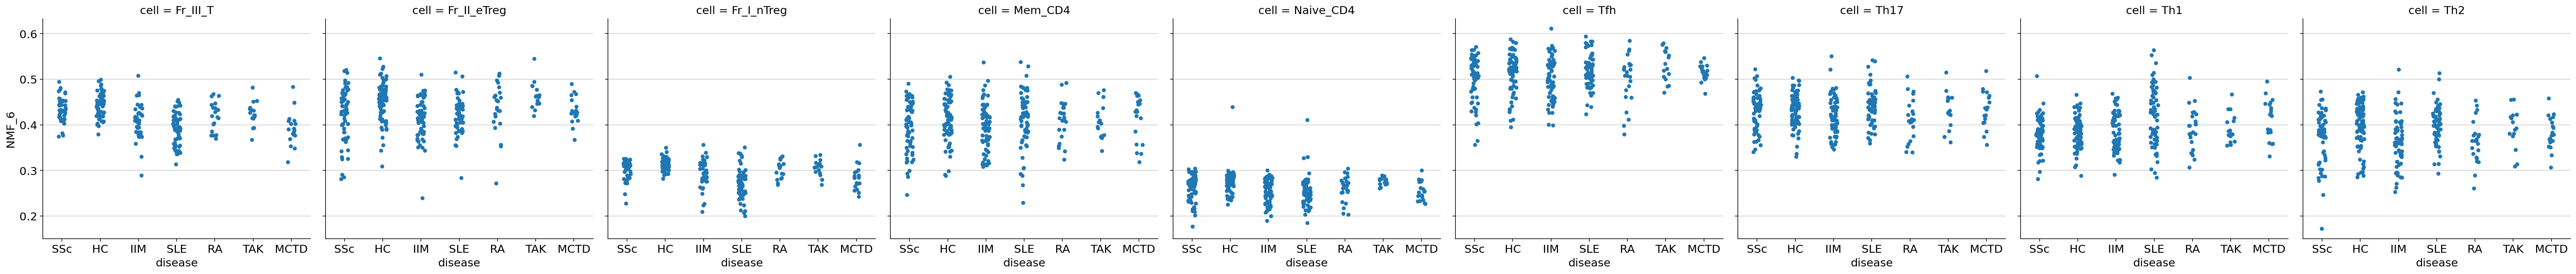

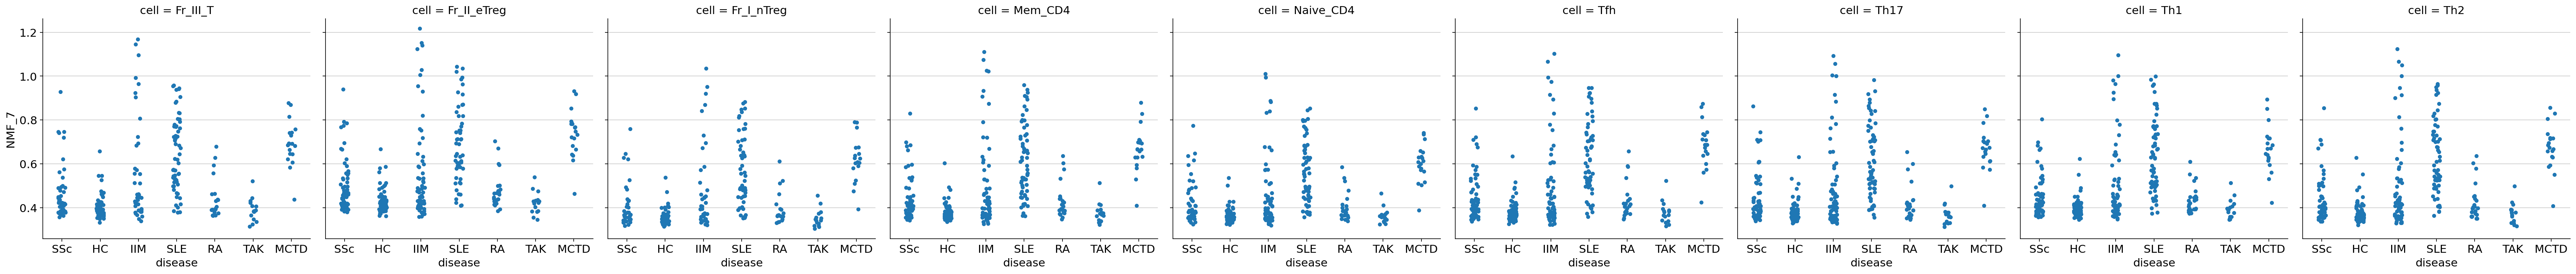

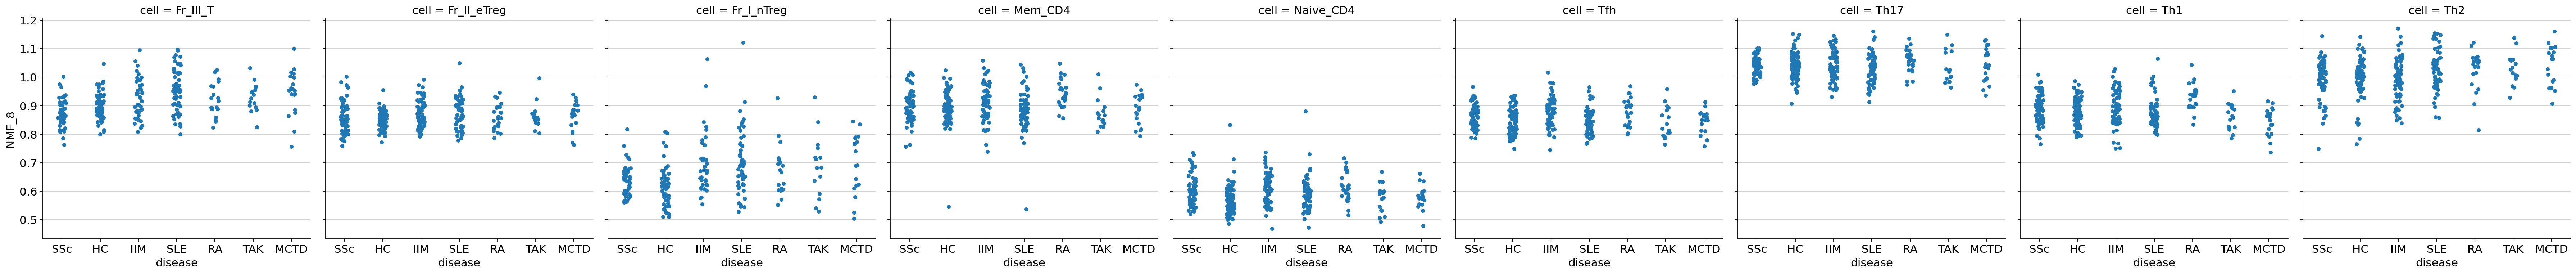

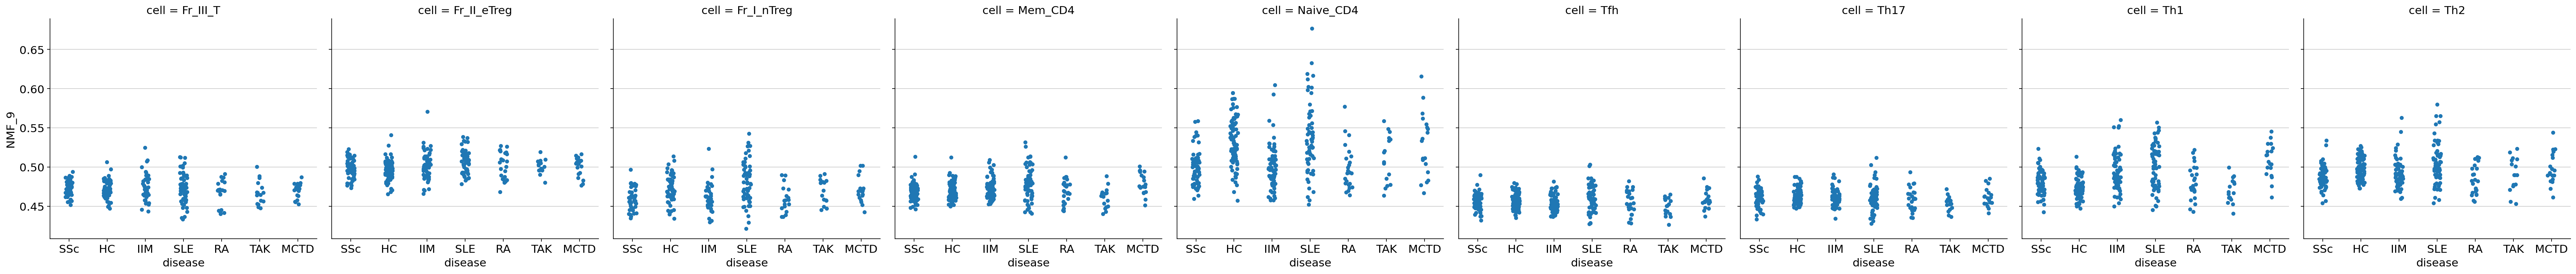

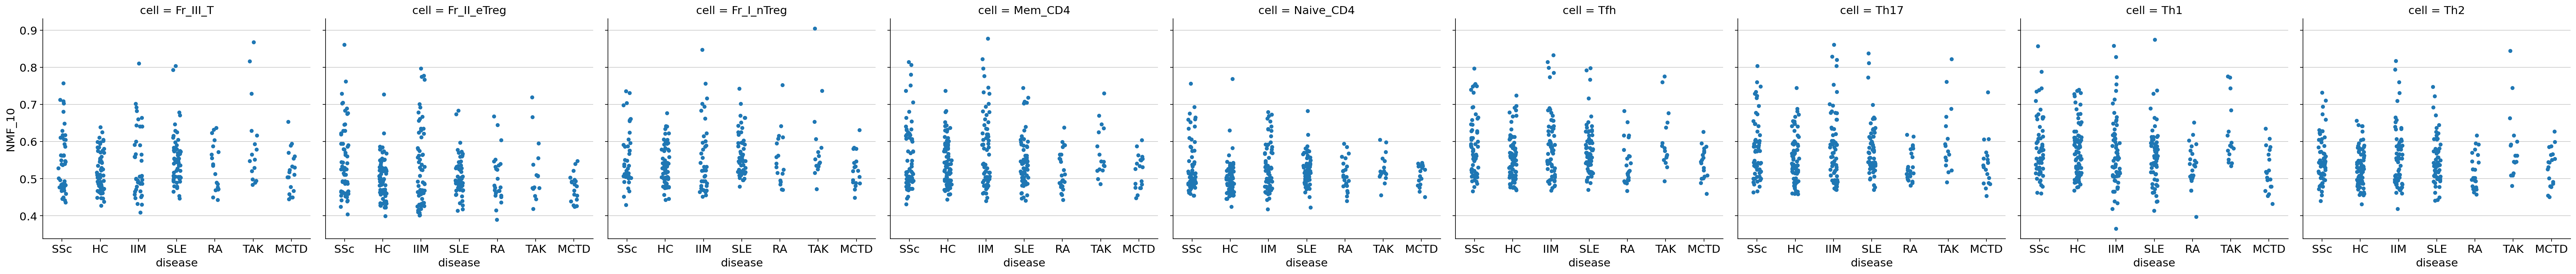

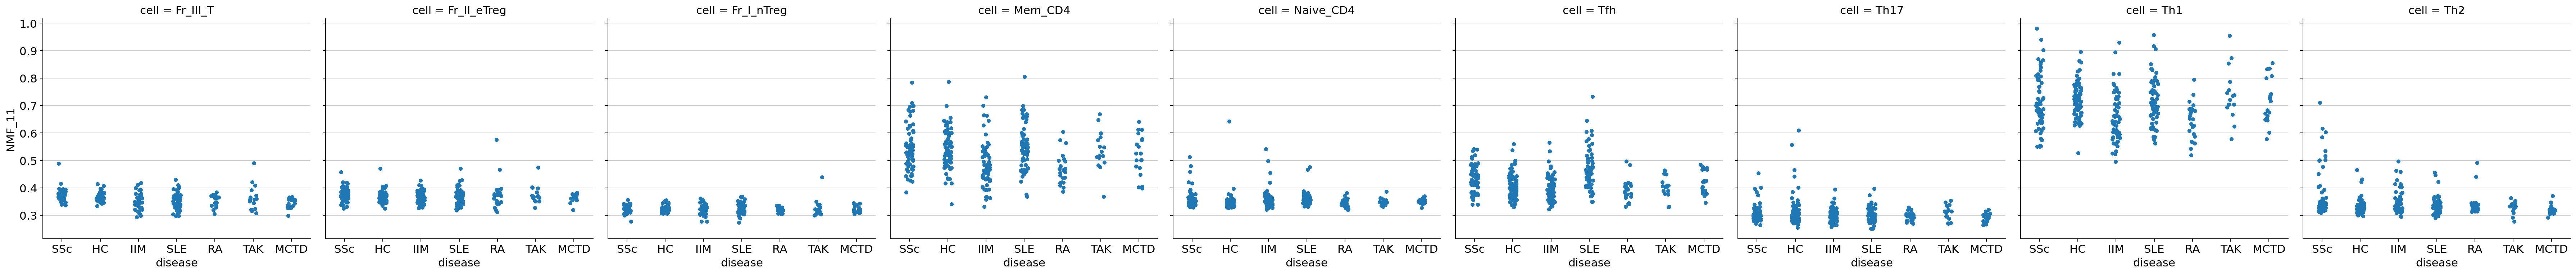

In [16]:
for nmf in df_proj.index:
    sns.catplot(data=df_proj_tidy, x='disease', y=nmf, col='cell')
    plt.savefig(str(sc.settings.figdir) + '/catplot_W{}_cat{}_NMF{}.pdf'.format(w,cat,nmf), bbox_inches='tight')

In [17]:
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

In [18]:
variables = ['Age', 'Gender_Female', 'disease_IIM', 'disease_MCTD', 'disease_RA',
       'disease_SLE', 'disease_SSc', 'disease_TAK']

flag = 0
for nmf in df_proj.index:
    for cell in df_proj_tidy.cell.unique():
        d = df_proj_tidy[df_proj_tidy['cell'] == cell]
        d['Age'] = d['age'] / 25
        d['Gender_Female'] = pd.get_dummies(d['sex'])['F']
        d = pd.concat([d, pd.get_dummies(d['disease'], prefix='disease', drop_first=False).drop('disease_HC', axis=1)], axis=1)

        model = sm.OLS(d[nmf], sm.add_constant(d[[x for x in variables if x in d.columns]]))
        results = model.fit()
        summary = results.summary2()

        d_stats = summary.tables[1].reset_index()
        d_stats['NMF'] = nmf
        d_stats['cell'] = cell
        
        if flag == 0:
            df_stats = d_stats
            flag = 1
        else:
            df_stats = pd.concat([df_stats, d_stats]).reset_index(drop=True)
df_stats['qvalue'] = multi.multipletests(df_stats['P>|t|'])[1]

/tmp/ipykernel_1883075/2376941643.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Age'] = d['age'] / 25
/tmp/ipykernel_1883075/2376941643.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Gender_Female'] = pd.get_dummies(d['sex'])['F']
/home/yyasumizu/anaconda3/envs/scanpy1.8.1_cd4t/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/t

In [19]:
df_stats.to_csv('../NMFprojection/ImmuNexUT/230112_stats_cd4T_cd4T.csv')

In [20]:
df_stats

index     Coef.  Std.Err.           t          P>|t|    [0.025  \
0            const  0.839104  0.004438  189.091883  1.086581e-272  0.830364   
1              Age -0.000517  0.001773   -0.291412   7.709768e-01 -0.004009   
2    Gender_Female  0.002025  0.002866    0.706439   4.805705e-01 -0.003620   
3      disease_IIM  0.006759  0.003337    2.025290   4.389594e-02  0.000186   
4     disease_MCTD  0.003075  0.004158    0.739529   4.602767e-01 -0.005115   
..             ...       ...       ...         ...            ...       ...   
967   disease_MCTD -0.012161  0.012295   -0.989109   3.233690e-01 -0.036352   
968     disease_RA  0.006709  0.011669    0.574950   5.657358e-01 -0.016249   
969    disease_SLE  0.002996  0.008328    0.359797   7.192399e-01 -0.013389   
970    disease_SSc  0.040270  0.008844    4.553185   7.559616e-06  0.022868   
971    disease_TAK -0.004017  0.013263   -0.302838   7.622130e-01 -0.030112   

       0.975]     NMF      cell    qvalue  
0    0.847843   NMF_0  Fr_III_T  0.000000  
1    0.002976   NMF_0  Fr_III_T  1.000000  
2    0.007670   NMF_0  Fr_III_T  1.000000  
3    0.013331   NMF_0  Fr_III_T  1.000000  
4    0.011265   NMF_0  Fr_III_T  1.000000  
..        ...     ...       ...       ...  
967  0.012030  NMF_11       Th2  1.000000  
968  0.029667  NMF_11       Th2  1.000000  
969  0.019382  NMF_11       Th2  1.000000  
970  0.057671  NMF_11       Th2  0.005654  
971  0.022079  NMF_11       Th2  1.000000  

[972 rows x 10 columns]

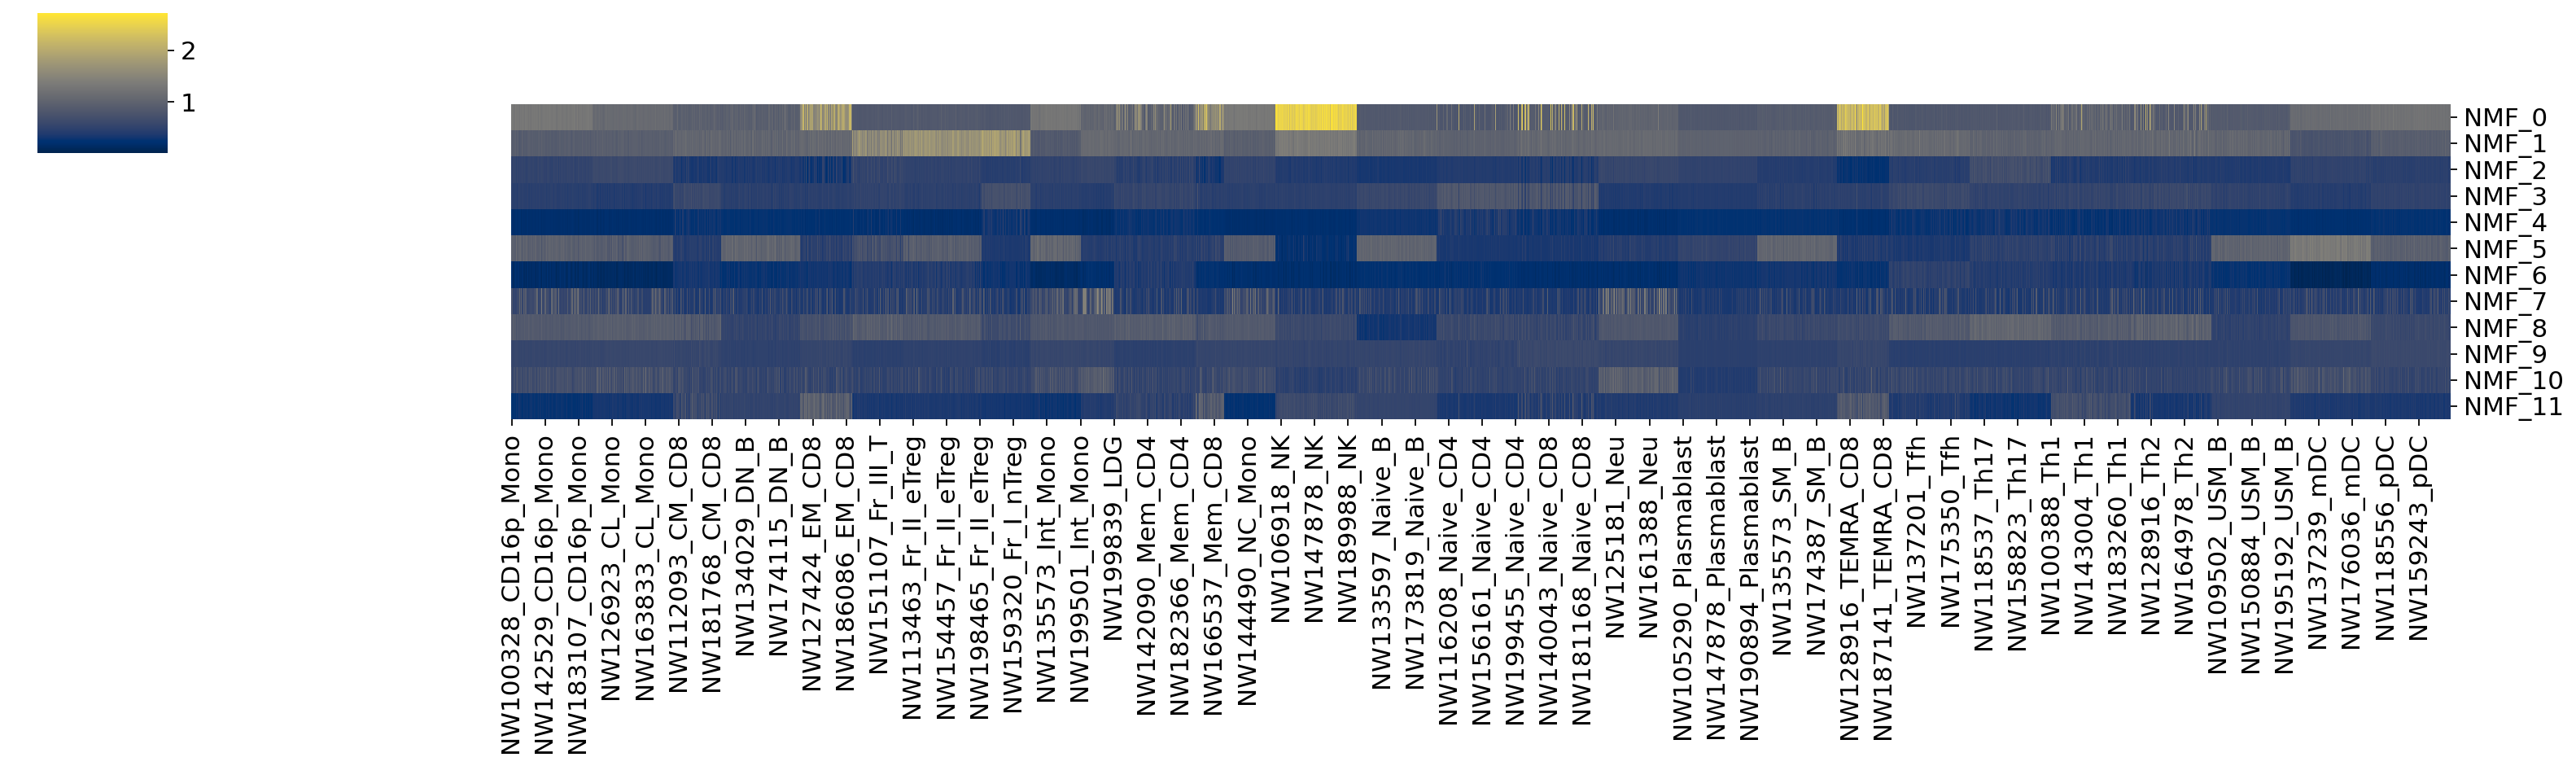

In [21]:
cat = 'All'
w = 'CD4T'
df_proj = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_projection.csv'.format(c=cat, w=w), 
    index_col=0)
df_evar = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_ExplainedVariance.csv'.format(c=cat, w=w), 
    index_col=0)
sns.clustermap(df_proj, col_cluster=False, row_cluster=False, figsize=(20,6), cmap='cividis')

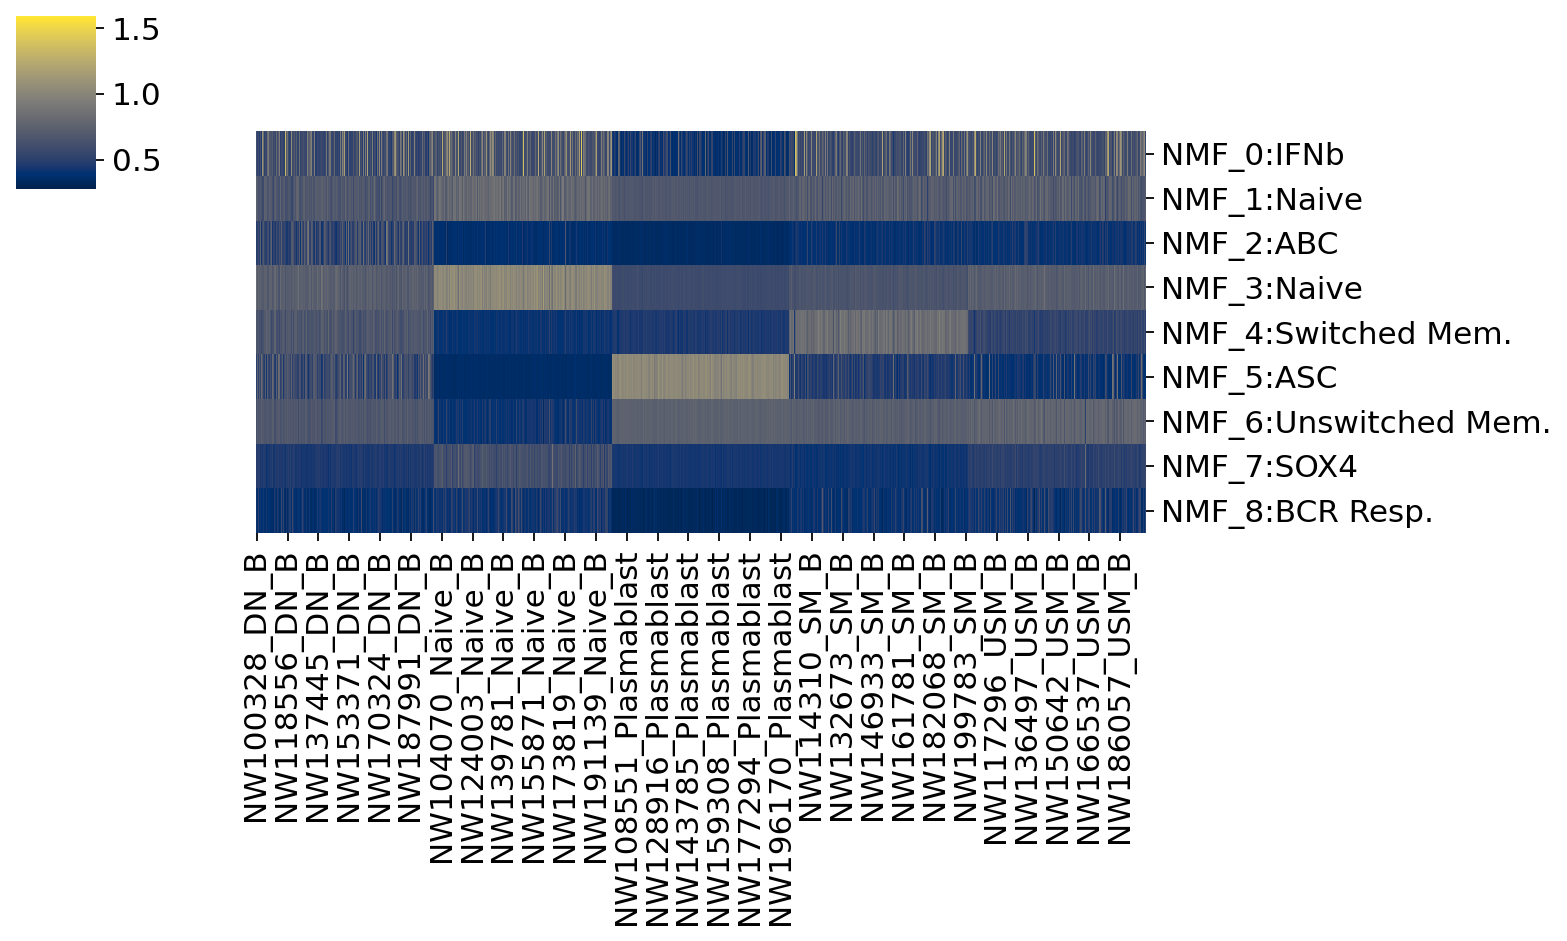

In [22]:
cat = 'B'
w = 'B'
list_nmf_annot = ['IFNb', 'Naive', 'ABC', 'Naive', 'Switched Mem.', 'ASC', 'Unswitched Mem.', 'SOX4', 'BCR Resp.']

df_proj = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_projection.csv'.format(c=cat, w=w), 
    index_col=0)
df_evar = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_ExplainedVariance.csv'.format(c=cat, w=w), 
    index_col=0)
df_proj.index = [c+':'+a for c,a in zip(df_proj.index, list_nmf_annot)]
sns.clustermap(df_proj, col_cluster=False, row_cluster=False, figsize=(10,6), cmap='cividis')

In [23]:
df_proj_tidy = df_proj.T
df_proj_tidy['id'] = df_proj_tidy.index.str.split('_').str.get(0)
df_proj_tidy['cell'] = ['_'.join(x[1:]) for x in df_proj_tidy.index.str.split('_')]
df_proj_tidy = pd.merge(df_proj_tidy, df_samples)
df_proj_tidy.head()

NMF_0:IFNb  NMF_1:Naive  NMF_2:ABC  NMF_3:Naive  NMF_4:Switched Mem.  \
0    0.592919     0.736806   0.482986     0.808429             0.667653   
1    0.630182     0.861670   0.362455     1.048249             0.387359   
2    0.448285     0.670087   0.337333     0.610725             0.446823   
3    0.627822     0.774801   0.378825     0.668510             0.779327   
4    0.599112     0.701511   0.493680     0.672361             0.802405   

   NMF_5:ASC  NMF_6:Unswitched Mem.  NMF_7:SOX4  NMF_8:BCR Resp.        id  \
0   0.494804               0.625891    0.479510         0.412818  NW100328   
1   0.354831               0.408363    0.634698         0.414607  NW100328   
2   1.093884               0.763029    0.450942         0.314688  NW100328   
3   0.417786               0.742093    0.446075         0.412670  NW100328   
4   0.615247               0.700714    0.439506         0.390369  NW100388   

          cell disease  Phase  age sex  
0         DN_B     SSc      2   53   F  
1      Naive_B     SSc      2   53   F  
2  Plasmablast     SSc      2   53   F  
3         SM_B     SSc      2   53   F  
4         DN_B     IIM      2   56   F

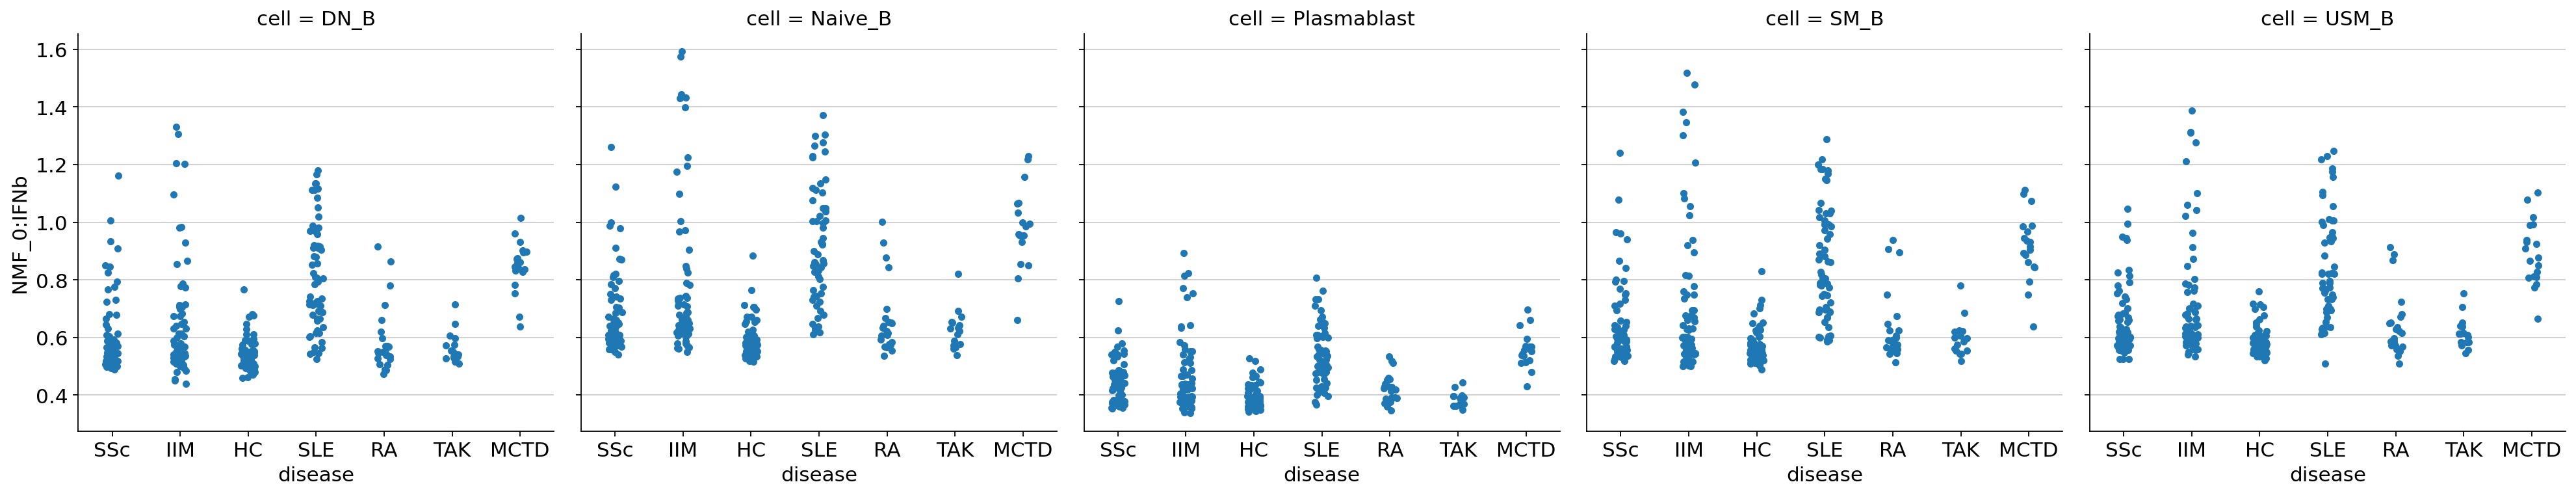

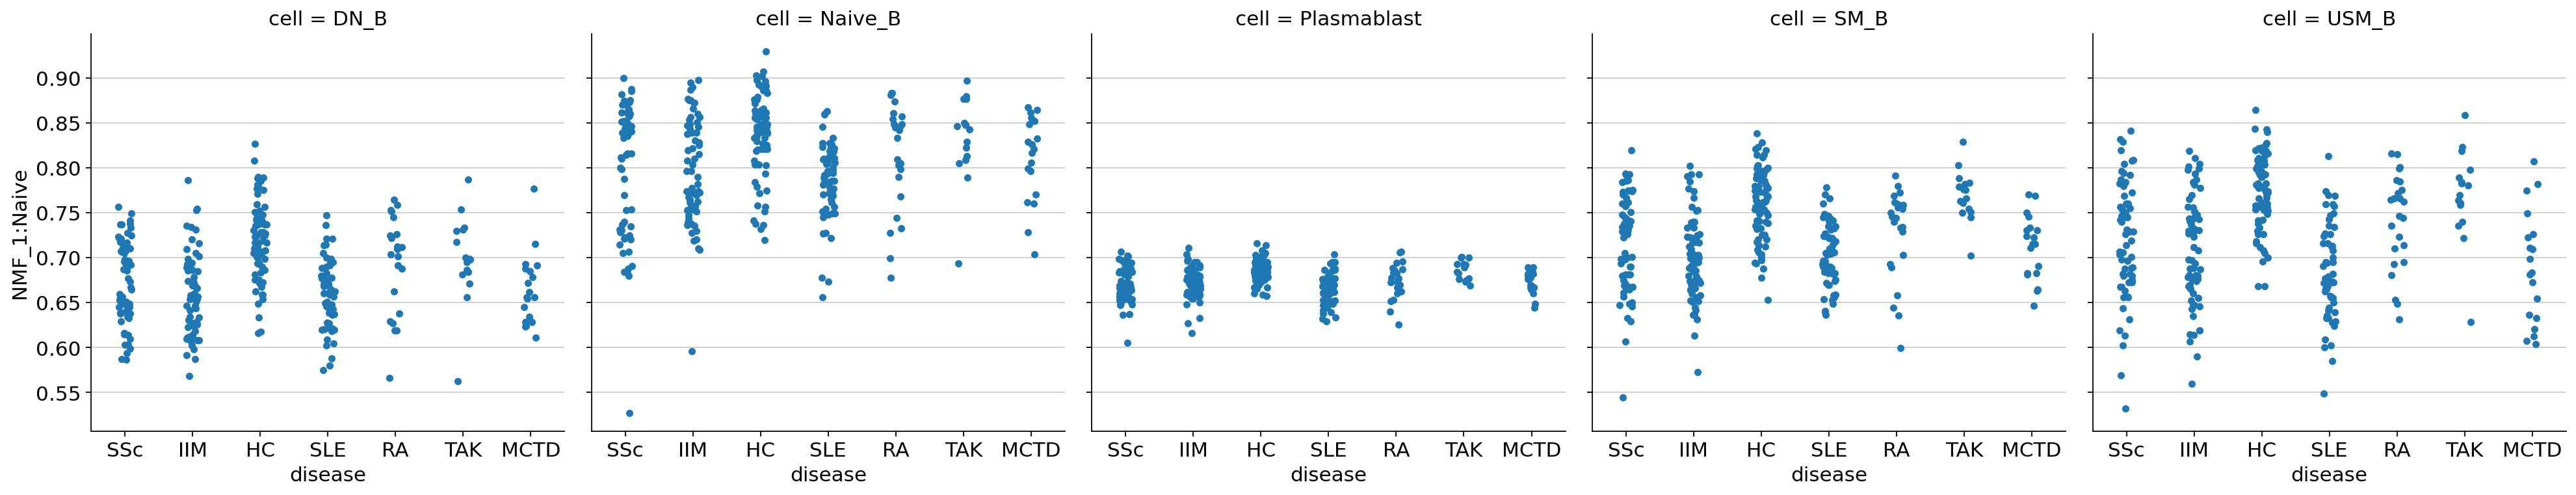

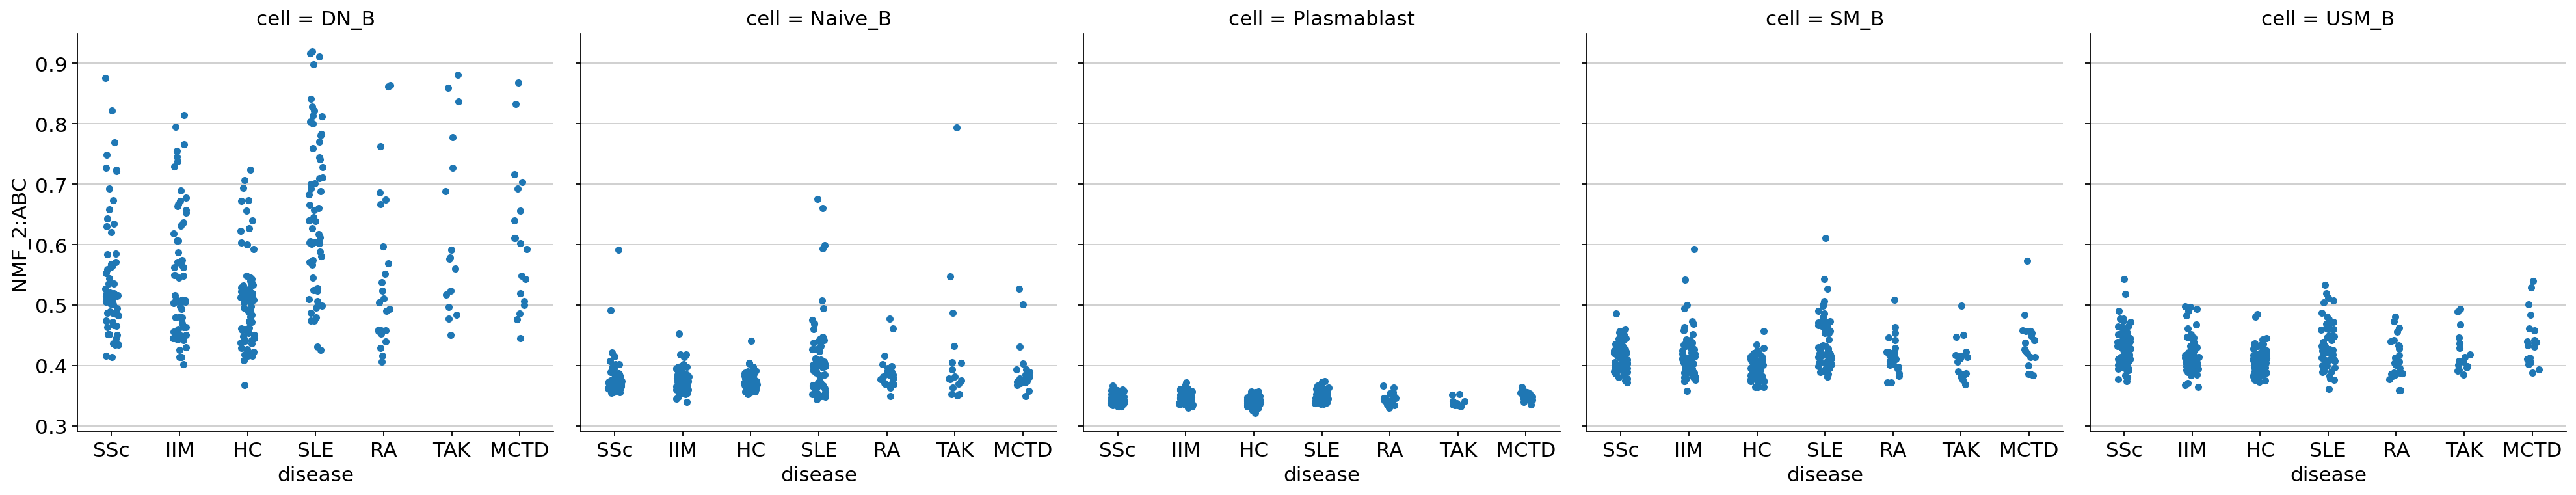

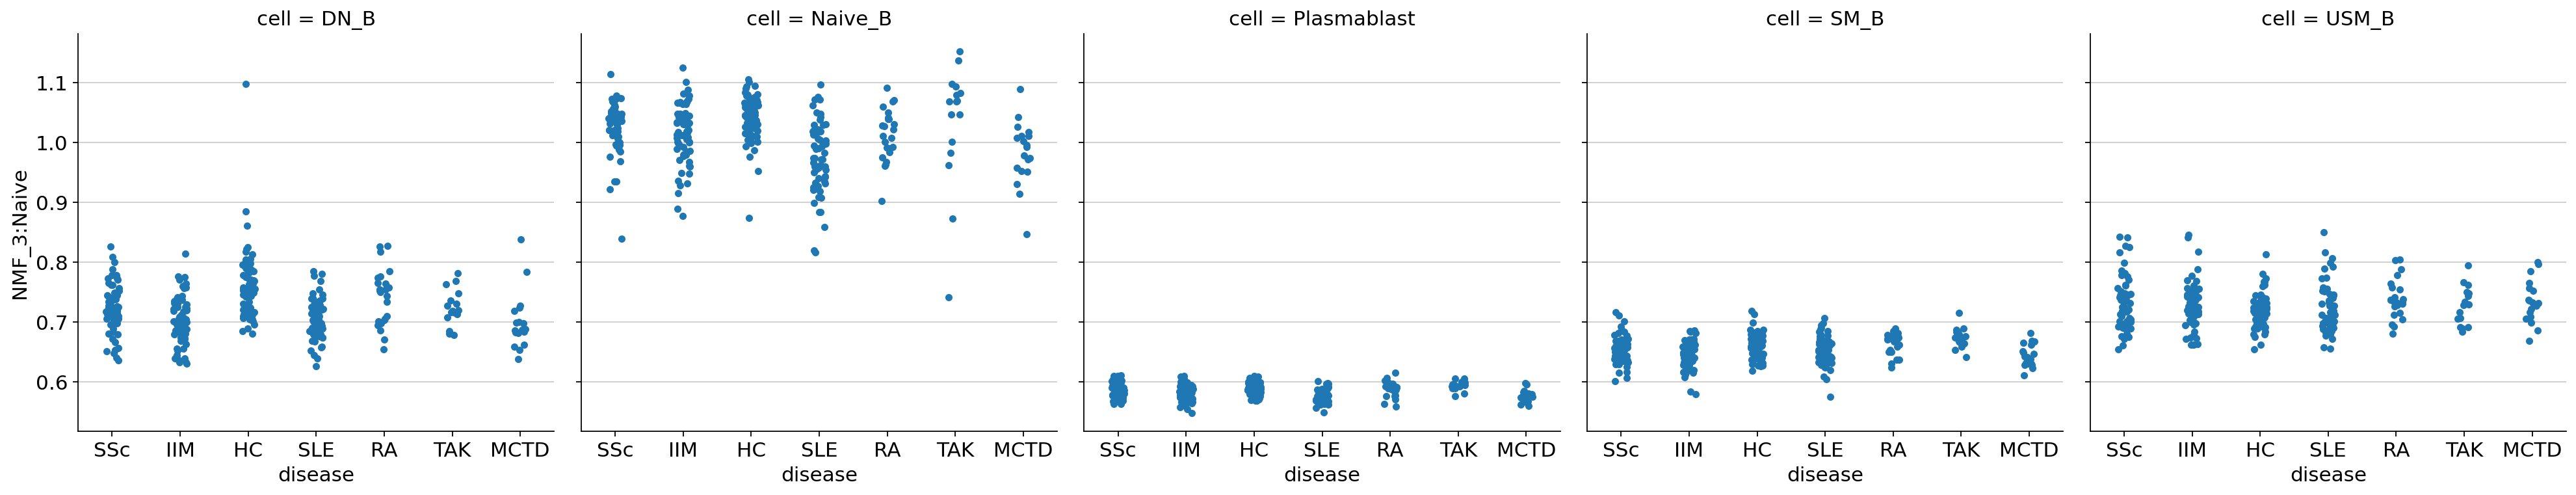

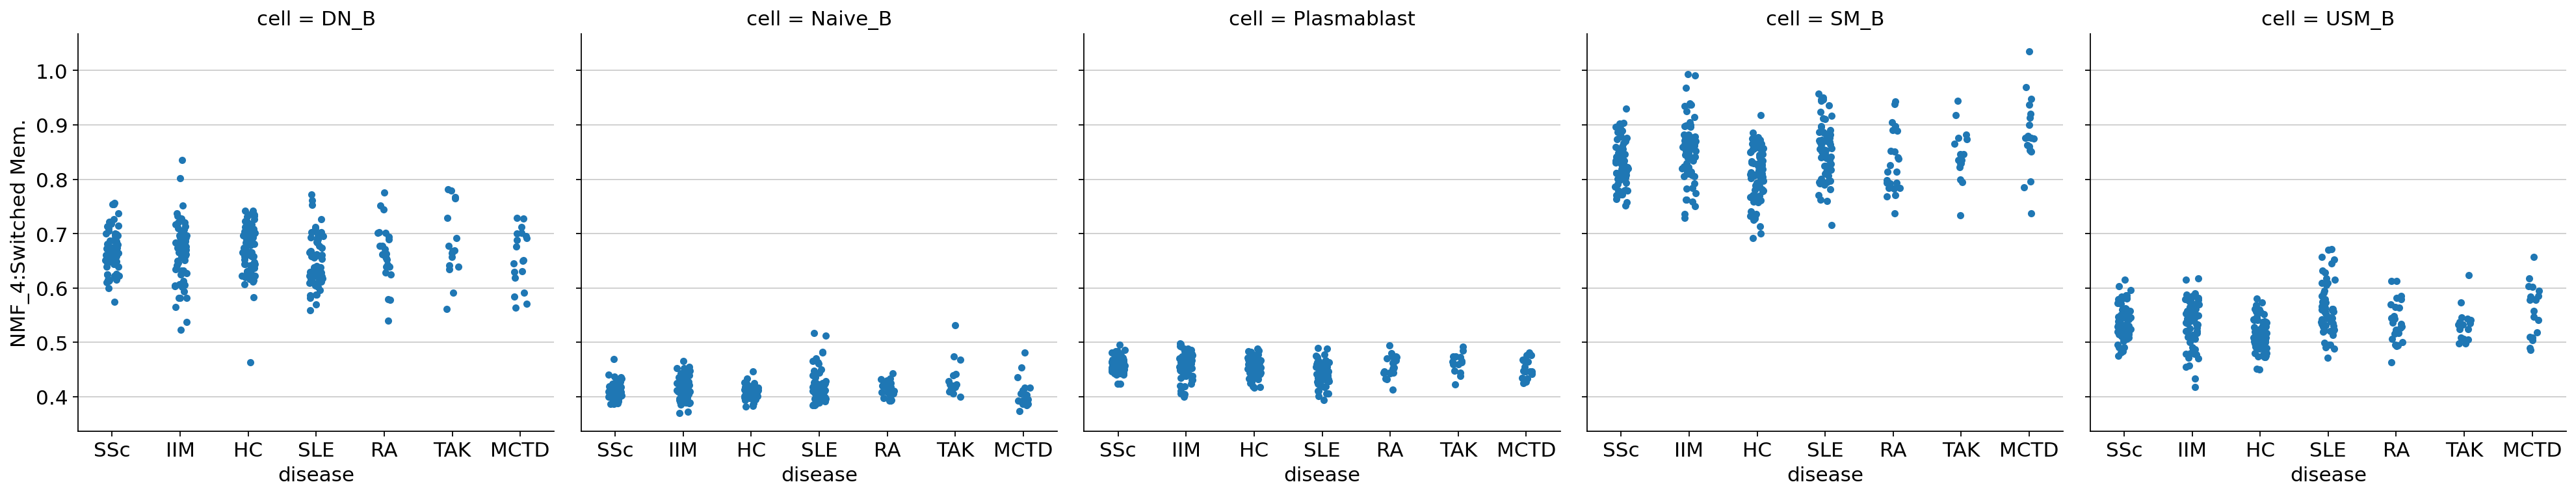

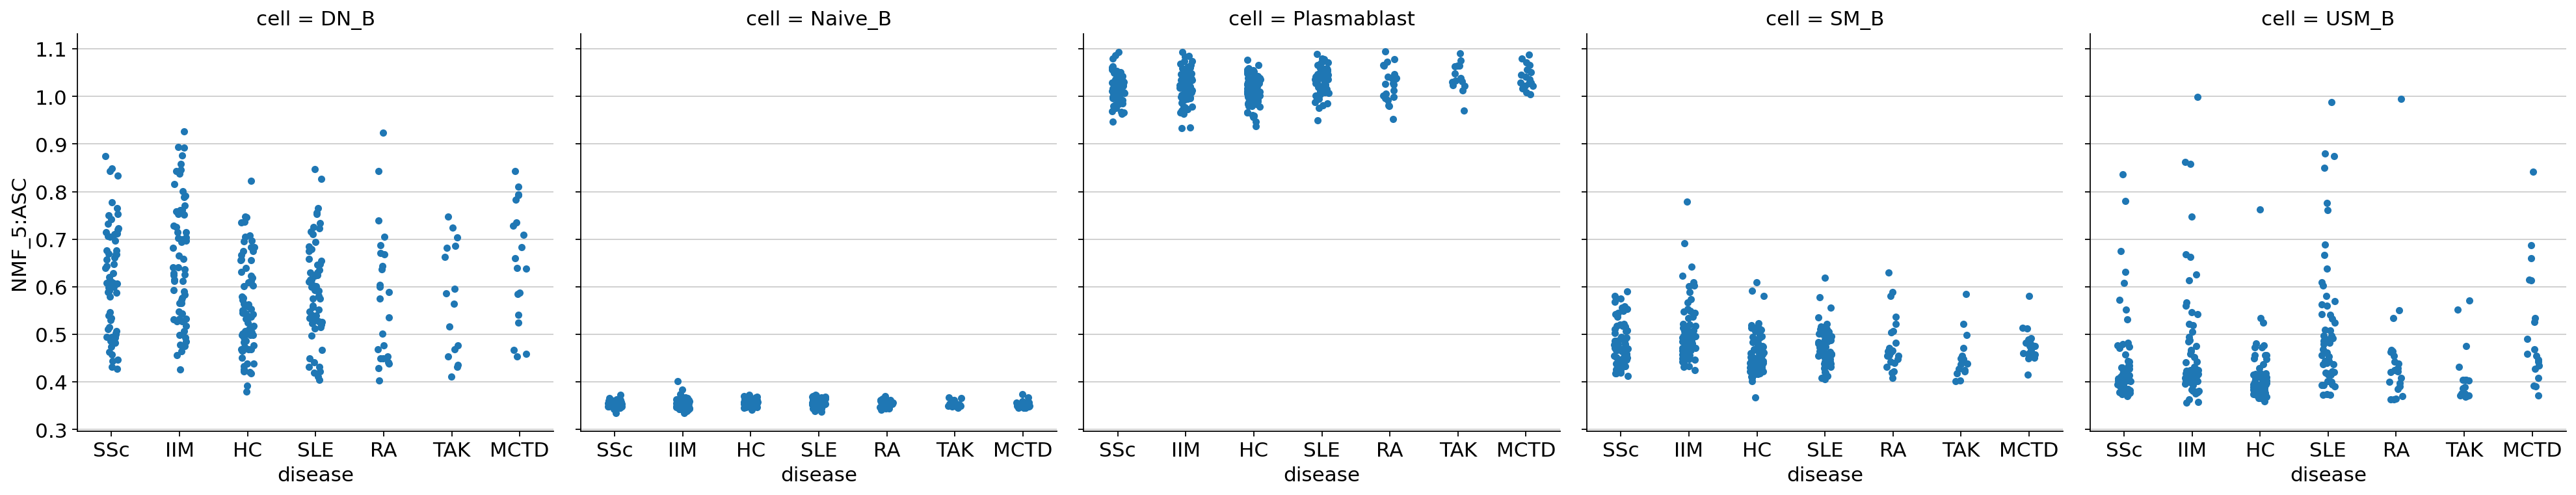

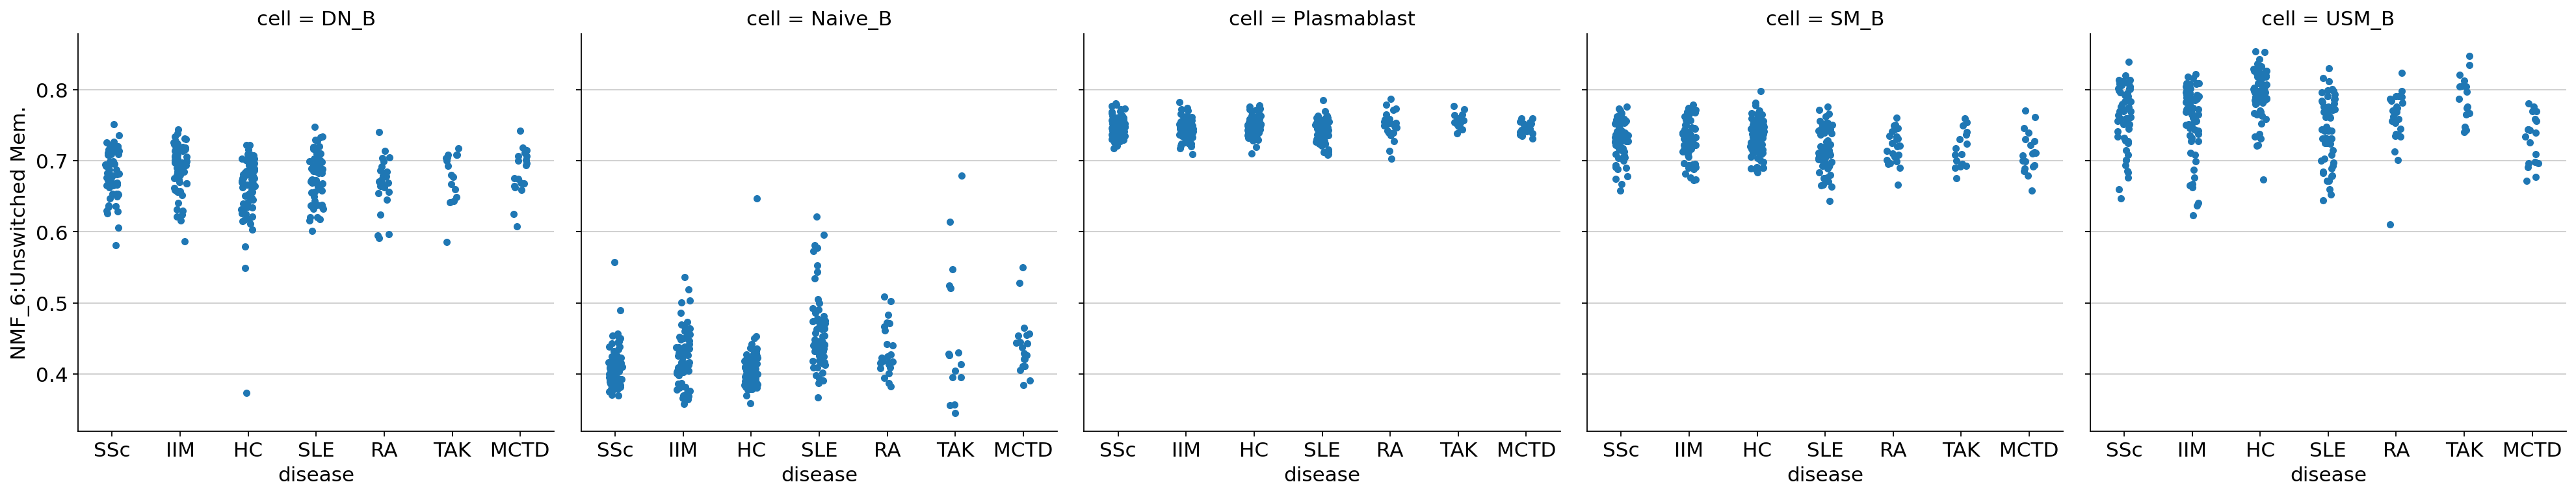

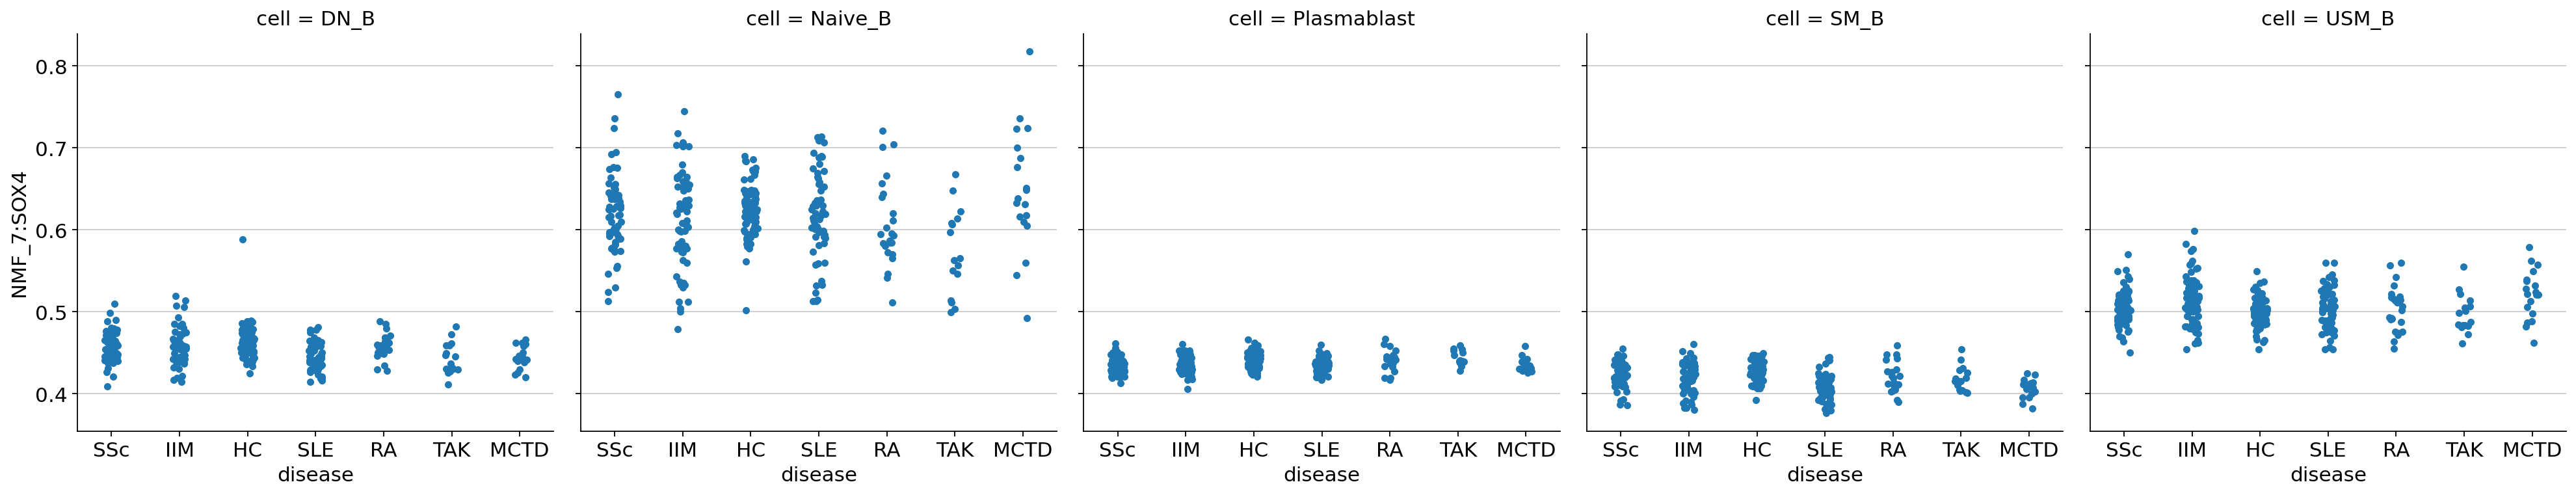

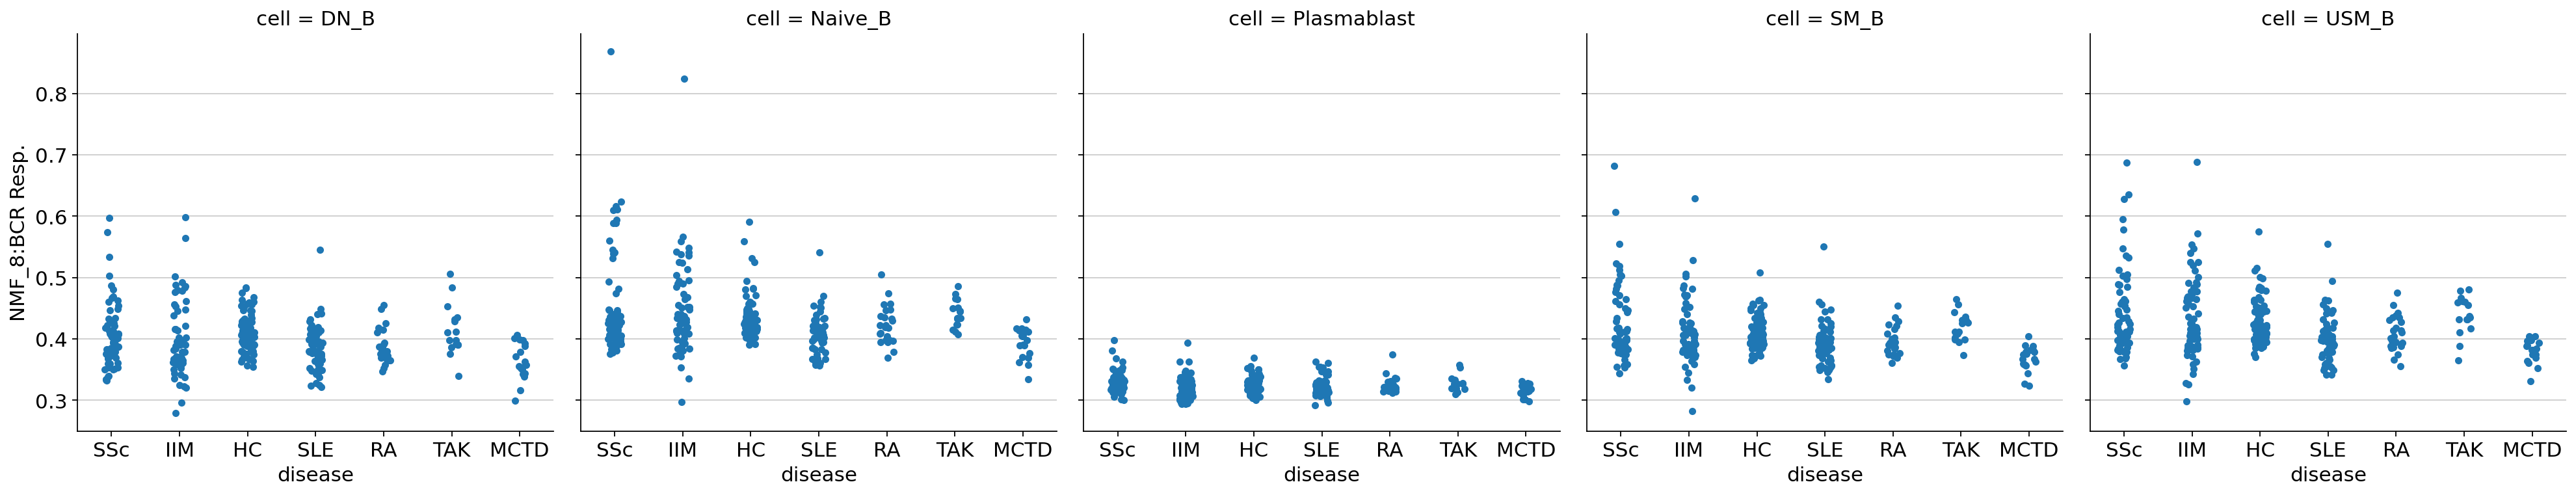

In [24]:
for nmf in df_proj.index:
    sns.catplot(data=df_proj_tidy, x='disease', y=nmf, col='cell')
    plt.savefig(str(sc.settings.figdir) + '/catplot_W{}_cat{}_NMF{}.pdf'.format(w,cat,nmf), bbox_inches='tight')

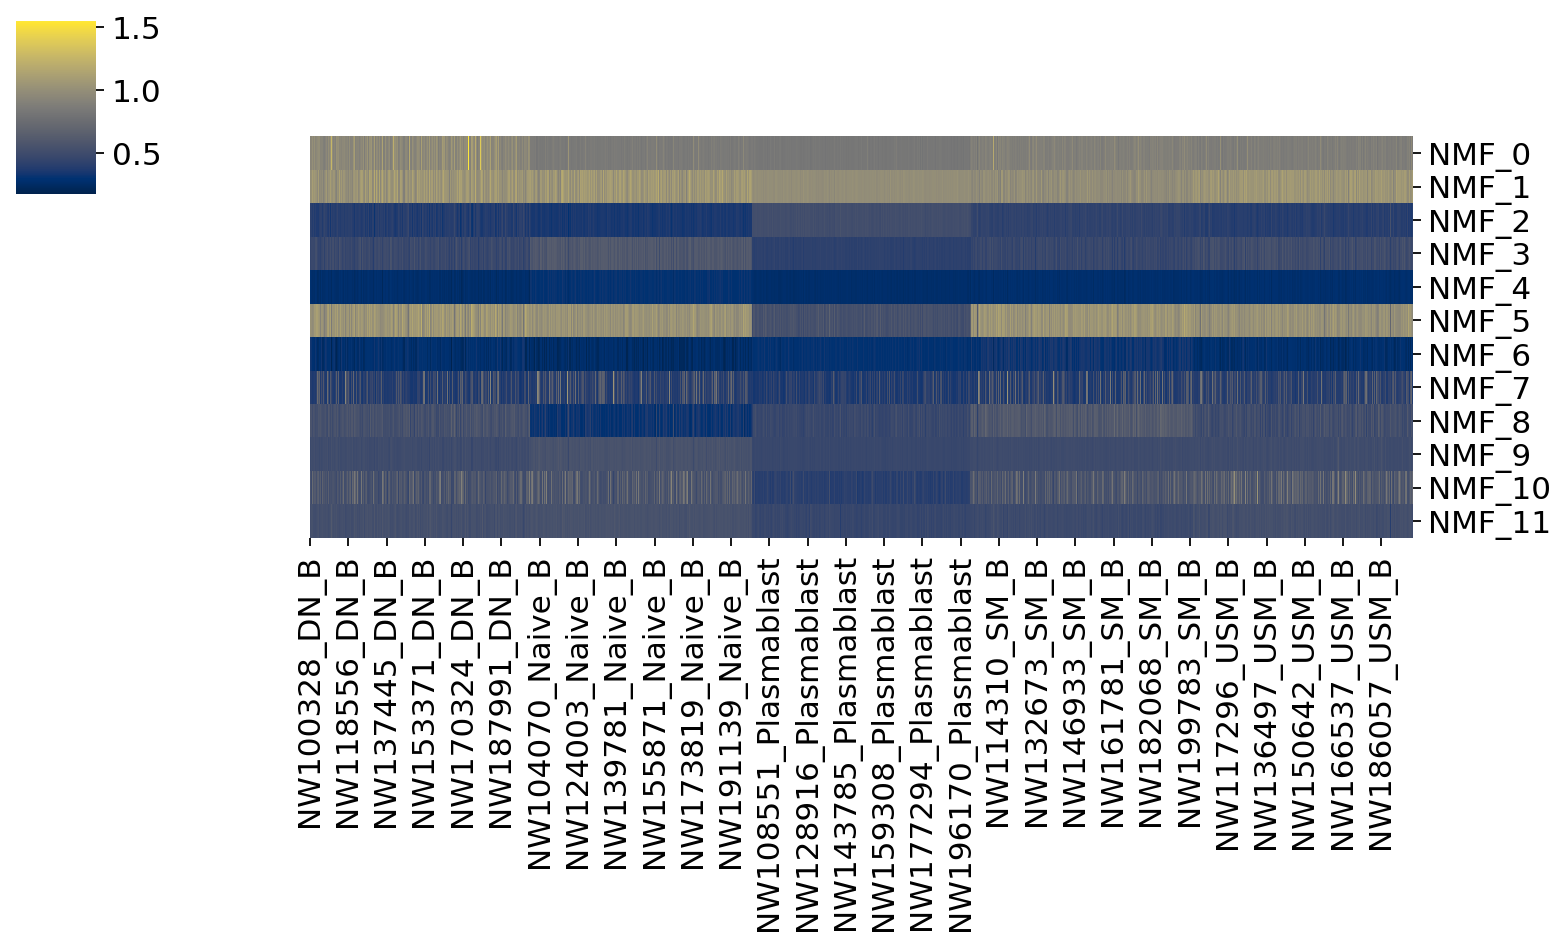

In [25]:
cat = 'B'
w = 'CD4T'
df_proj = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_projection.csv'.format(c=cat, w=w), 
    index_col=0)
df_evar = pd.read_csv('/home/yyasumizu/media32TB/bioinformatics/autoimmune_10x/NMFprojection/ImmuNexUT/{c}_{w}_ExplainedVariance.csv'.format(c=cat, w=w), 
    index_col=0)
sns.clustermap(df_proj, col_cluster=False, row_cluster=False, figsize=(10,6), cmap='cividis')